In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


In [3]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

## I. OneHotEncoder

In [4]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [4]:
# Pour "Merchant State" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10) #on se limite aux 10 premières catégories

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "Merchant City" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

## II. Sorting the columns and creating X1, y

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'day_of_week', 'Hours', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_18h_nbt',
       'last_18h_amt', 'last_3d_amt/nbt', 'Is Fraud?', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [7]:
selection = ['User', 'Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']

In [8]:
estimators = ['User', 'Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday']
df_selec = df_cct[selection]
#df_selec = df_selec[np.isfinite(df_selec).all(1)]
X1 = df_selec[estimators]
y = df_selec["Is Fraud?"]


In [9]:
#X1.fillna(0, inplace=True)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    train_size = 0.60, test_size = 0.40, random_state = 1, stratify = y)

In [10]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression

In [11]:
model = make_pipeline(RobustScaler(), LogisticRegression())

In [12]:
model.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression())])

In [13]:
y_pred = model.predict(X_test)

In [14]:
model.score(X_test, y_test)

0.998777212355814

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   9742857
           1       0.35      0.00      0.00     11903

    accuracy                           1.00   9754760
   macro avg       0.67      0.50      0.50   9754760
weighted avg       1.00      1.00      1.00   9754760



In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

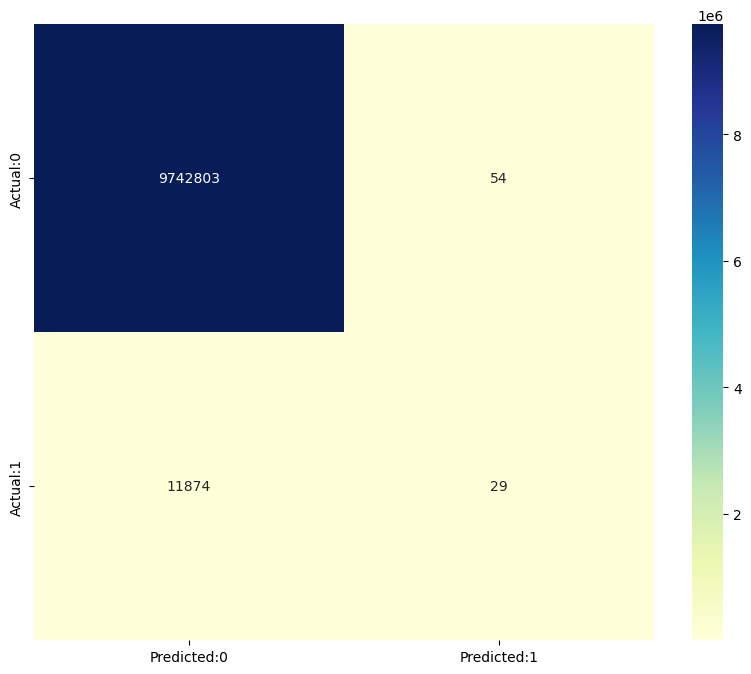

In [17]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [18]:
cm

array([[9742803,      54],
       [  11874,      29]])

In [19]:
X_train

,User,Card,Month,Day,Hours,Amount,delta_t_s,delta_t_s_card,amt/daily_income,Retired,...,Chip Transaction,Online Transaction,Swipe Transaction,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
12575551,1034,1,10,30,6,78.35,0,0,0.718374,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12017780,990,1,4,1,10,19.62,55740,55740,0.220905,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8439658,724,0,12,23,17,120.00,28680,28680,0.449438,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14584545,1194,0,8,11,11,3.62,152640,152640,0.031995,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10625211,889,1,8,16,18,46.59,13020,13020,0.454883,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445861,288,4,6,21,14,112.77,3480,41220,2.141017,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5829026,490,5,10,3,13,104.89,7860,7860,0.953759,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24095393,1974,1,3,3,10,125.12,53160,56340,1.421553,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9661931,815,0,7,4,16,33.66,4440,4440,0.203773,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
